In [1]:

from gurobipy import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt


In [28]:
# ---------- Data ----------

# Open the file and read the data
with open('data_small_multiTW.txt', 'r') as f:
    data = f.readlines()

CVRPTW = []
for line in data:
    parts = line.split()
    loc_id = int(parts[0])
    x_coord = int(parts[1])
    y_coord = int(parts[2])
    demand = int(parts[3])
    service_time = int(parts[4])
    num_tw = int(parts[5])
    time_windows = []
    for n in range(num_tw):
        start = int(parts[6 + 2*n])
        end = int(parts[7 + 2*n])
        time_windows.append((start, end))

    # Combine location data with the time windows
    CVRPTW.append([loc_id, x_coord, y_coord, demand, service_time] + time_windows)

# Convert list to numpy array for easier manipulation
CVRPTW = np.array(CVRPTW, dtype=object)

Nodes = CVRPTW[:, 0]  # nodes
n = len(Nodes)  # number of nodes

Vehicles = {0, 1, 2, 3, 4}  # vehicles

xcoord = CVRPTW[:, 1]  # x coordinates
ycoord = CVRPTW[:, 2]  # y coordinates
q = CVRPTW[:, 3]  # demand
service_duration = CVRPTW[:, 4]  # service time

# Extract time windows for each node
time_windows = CVRPTW[:, 5:].tolist()

Q = 70  # vehicle capacity
BIGM = 123456  # big M

# Calculate the distance matrix
distance = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            distance[i, j] = math.sqrt((xcoord[i] - xcoord[j])**2 + (ycoord[i] - ycoord[j])**2)
            # if i == j:
                # distance[i, j] = BIGM  # Set a large penalty for self-loops\n",
# ---------- Optimization Model ----------

# Initialize the model
m = Model("CVRPTW_MultiTW")

# Decision Variables
# x_{ijv}: Binary variable, 1 if vehicle v travels from i to j, 0 otherwise
edge = {}
for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            edge[i, j, v] = m.addVar(vtype=GRB.BINARY, lb=0, name='x_%s_%s_%s' % (i, j, v))

# service_start{ivw}: Time at which vehicle v starts service at node i at time window w
service_start = {}
for i in Nodes:
    for v in Vehicles:
            service_start[i, v] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name='t_%s_%s' % (i, v))

# z_{ivw}: Binary variable, 1 if node i is visited by vehicle v during time window w
z = {}
for i in Nodes:
    for v in Vehicles:
        for w in range(len(time_windows[int(i)])):
            z[i, v, w] = m.addVar(vtype=GRB.BINARY, lb=0, name='z_%s_%s_%s' % (i, v, w))

m.update()


# Objective Function
obj = quicksum(distance[i,j]*edge[i,j,v] for i in Nodes for j in Nodes for v in Vehicles)
m.setObjective(obj)
m.ModelSense = GRB.MINIMIZE
m.update()

# Constraints

# each node is visited by exactly one vehicle 1
con0 = {}
for v in Vehicles:
    for i in Nodes:
        con0[i,i,v] = m.addConstr(
            edge[i,i,v] == 0, 'con0[' + str(i) + ',' + str(i) + ',' + str(v) + ']'
        )

# 
con1 = {}
for i in Nodes:
    for v in Vehicles:
        con1[i,j,v] = m.addConstr(
            quicksum(edge[i,j,v] for j in Nodes) == quicksum(z[i, v, w] for w in range(len(time_windows[int(i)]))), 'con1[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
        )



con11 = {}
for i in Nodes:
    if i != 0:
        con11[i,v,w] = m.addConstr(
            quicksum(z[i,v,w] for v in Vehicles for w in range(len(time_windows[int(i)]))) == 1, 'con11[' + str(i) + ',' + str(v) + ',' + str(w) + ']'
        )

    
# each vehicle starts and ends at the depot
con2 = {}
con3 = {}
for v in Vehicles:
    con2[v] = m.addConstr(
        quicksum(edge[0,i,v] for i in Nodes if i != 0) <= 1, 'con2[' + str(v) + ']'
    )
    con3[v] = m.addConstr(
        quicksum(edge[i,0,v] for i in Nodes if i != 0) <= 1, 'con3[' + str(v) + ']'
    )


# Capacity constraint
con4 = {}
for v in Vehicles:
    con4[v] = m.addConstr(
        quicksum(q[i]*z[i,v,w] for i in Nodes for w in range(len(time_windows[int(i)]))) <= Q, 'con4[' + str(v) + ']'
    )


# Flow conservation excluding self-loops
con5 = {}
for i in Nodes:
    for v in Vehicles:
        con5[i, j, v] = m.addConstr(
            quicksum(edge[i, j, v] for j in Nodes) == quicksum(edge[j, i, v] for j in Nodes),
            'con5[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
        )


# time window constraints
con6 = {}
con7 = {}
con8 = {}
con9 = {}
for i in Nodes:
    for v in Vehicles:
        for w in range(len(time_windows[int(i)])):
            a_iw, b_iw = time_windows[int(i)][w]
            con6[i,v,w] = m.addConstr(
                service_start[i, v] + BIGM * (1 - z[i, v, w]) >= a_iw, 'con6[' + str(i) + ',' + str(v) + str(w) + ']'
                )
            con7[i,v,w] = m.addConstr(
                service_start[i, v] - BIGM * (1 - z[i, v, w]) <= b_iw, 'con7[' + str(i) + ',' + str(v) + str(w) +']'
                )

for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):   
                if i != j and i != 0 and j != 0:
                    con8[i,j,v,w] = m.addConstr(
                        service_start[j, v] >= service_start[i, v] + service_duration[int(i)] + distance[i, j] - BIGM * (1 - edge[i, j, v]), 'con8[' + str(i) + ',' + str(j) + ',' + str(v) + ',' + str(w) + ']'
                    )

# Waiting time
# for i in Nodes:
#     for v in Vehicles:
#         for w in range(len(time_windows[int(i)])):
#             a_iw, b_iw = time_windows[int(i)][w]
#             con9[i,v,w] = m.addConstr(service_start[i, v, w] + wait_time[i, v] <= a_iw * z[i, v, w], 'con9[' + str(i) + ',' + str(v) + ',' + str(w) + ']')


# Solve
m.update()
m.write('CVRPTW.lp')
m.Params.TimeLimit = 30600
m.optimize()

if m.status == GRB.OPTIMAL:
    print("Optimal Solution found.")
    print("Time window, in which the nodes are visited:")
    for i in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):
                if z[i, v, w].X > 0.5:  # z[i, v, w].X gibt den Wert der Variablen nach der Optimierung an
                    a_iw, b_iw = time_windows[int(i)][w]
                    print(f"Node {i} is visited by vehicle {v} in time window ({a_iw}, {b_iw}).")
else:
    print("No optimal solution found.")

if m.status == GRB.OPTIMAL:
    print("Optimal Solution found .")
    print("Service-Start Times:")
    for i in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):
                if z[i, v, w].X > 0.5:  # Prüft, ob das Fahrzeug i im Zeitfenster w besucht
                    start_time = service_start[i, v].X
                    print(f"Vehicle {v} starts service at node {i} in time window {w} at {start_time:.2f}.")
else:
    print("No optimal solution found.")

#Debugging
if m.status == GRB.INFEASIBLE:
    m.computeIIS() 

    for c in m.getConstrs():
        if c.IISConstr: 
            print('Impossible constraint:', c.constrName)

    for v in m.getVars():
        if v.IISLB > 0 or v.IISUB > 0:
            print('Problem with variable:', v.varName)


Set parameter TimeLimit to value 30600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1268 rows, 585 columns and 4685 nonzeros
Model fingerprint: 0xab7d5732
Variable types: 45 continuous, 540 integer (540 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [4e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 800 rows and 65 columns
Presolve time: 0.02s
Presolved: 468 rows, 520 columns, 2640 nonzeros
Variable types: 40 continuous, 480 integer (480 binary)
Found heuristic solution: objective 260.3101387
Found heuristic solution: objective 208.0832829

Root relaxation: objective 8.540519e+01, 174 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bound

C:\Users\kai-s\AppData\Local\Temp\ipykernel_7124\4046240107.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_vehicles)  # Use 'tab20' for up to 20 distinct colors


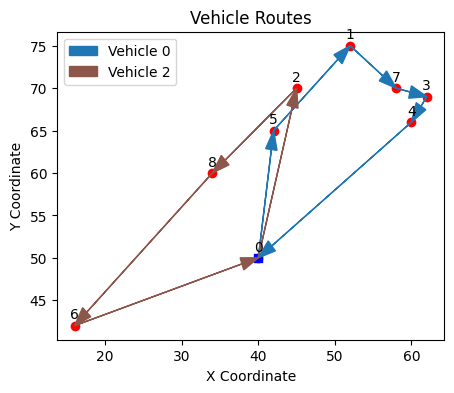

In [29]:
# Extract the routes from the solution
routes = {v: [] for v in Vehicles}
if m.status == GRB.OPTIMAL:
    for v in Vehicles:
        for i in Nodes:
            for j in Nodes:
                if edge[i, j, v].X > 0.5:
                    routes[v].append((i, j))

    # Plot the routes
    plt.figure(figsize=(5, 4))
    plt.scatter(xcoord, ycoord, c='red')
    plt.scatter(xcoord[0], ycoord[0], c='blue', marker='s')  # depot

    for i, (x, y) in enumerate(zip(xcoord, ycoord)):
        plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    num_vehicles = len(Vehicles)
    cmap = plt.cm.get_cmap('tab20', num_vehicles)  # Use 'tab20' for up to 20 distinct colors
    colors = [cmap(i) for i in range(num_vehicles)]  # Extract `num_vehicles` colors
    for v in Vehicles:
        for (i, j) in routes[v]:
            plt.arrow(xcoord[i], ycoord[i], xcoord[j] - xcoord[i], ycoord[j] - ycoord[i], 
                      color=colors[v], head_width=1.5, length_includes_head=True, label=f'Vehicle {v}' if i == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.legend()
    plt.show()
else:
    print("No optimal solution found.")


In [25]:
# Create a dataframe to store the results for all vehicles
df_all = pd.DataFrame(columns=['Vehicle', 'Node', 'Service Start', 'Load'])

for v in Vehicles:
    print(f"Vehicle {v} service times and loads:")
    sorted_routes = sorted(routes[v], key=lambda x: service_start[x[0], v].X)
    load = 0
    for (i, j) in sorted_routes:
        load += q[i]
        print(f"  Node {i}: Service start at {service_start[i, v].X:.2f}, Load: {load}")
        new_row = pd.DataFrame({'Vehicle': [v], 'Node': [i], 'Service Start': [service_start[i, v].X], 'Load': [load]})
        if not new_row.isna().all(axis=None):
            df_all = pd.concat([df_all, new_row], ignore_index=True)

    print("\n")

df_all
# show the total distance travveled by all vehicles
total_distance = 0
for v in Vehicles:
    for (i, j) in routes[v]:
        total_distance += distance[i, j]
print(f"Total distance traveled by all vehicles: {total_distance:.2f}")

Vehicle 0 service times and loads:
  Node 0: Service start at 0.00, Load: 0
  Node 5: Service start at 25.00, Load: 10
  Node 2: Service start at 213.00, Load: 40
  Node 1: Service start at 311.60, Load: 50
  Node 7: Service start at 1100.00, Load: 70
  Node 3: Service start at 1194.12, Load: 80
  Node 4: Service start at 1287.73, Load: 90
  Node 8: Service start at 1404.41, Load: 110
  Node 6: Service start at 2957.00, Load: 130


Vehicle 1 service times and loads:


Vehicle 2 service times and loads:


Vehicle 3 service times and loads:


Vehicle 4 service times and loads:


Total distance traveled by all vehicles: 122.54


C:\Users\kai-s\AppData\Local\Temp\ipykernel_7124\2526418937.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, new_row], ignore_index=True)
